In [1]:
%matplotlib inline
import sys
sys.path.append('../')
import importlib
import matplotlib.pyplot as plt
import numpy as np
import knowyourdata as kyd

import pandas as pd
from traffic_prophet import cfg
import pathlib, os
import configparser

from traffic_prophet import connection
from traffic_prophet.countmatch import reader
from traffic_prophet.countmatch import growthfactor as gf
from traffic_prophet.countmatch import neighbour

defaultcolours = plt.rcParams['axes.prop_cycle'].by_key()['color']

filepath = pathlib.Path.home().joinpath('.charlesconfig')
if os.path.isfile(filepath):
    vol_conn = connection.Connection(filepath, 'POSTGRES',
                                     'czhu.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'POSTGRES',
                                    'czhu.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['MAPBOX']['token']
    PLOTLY_USER = config['PLOTLY']['user']
    PLOTLY_KEY = config['PLOTLY']['key']
else:
    filepath = pathlib.Path.home().joinpath('cf.txt')
    vol_conn = connection.Connection(filepath, 'localpg',
                                     'prj_vol.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'localpg',
                                    'gis.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['mapbox']['token']
    PLOTLY_USER = config['plotly']['user']
    PLOTLY_KEY = config['plotly']['apikey']

In [2]:
rdr = reader.Reader(vol_conn)
rdr.read()
gf.get_growth_factors(rdr)

ptc_ids = np.unique(np.abs(list(rdr.ptcs.keys())))
nb = neighbour.NeighbourLonLatEuclidean(ll_conn, 20, ptc_ids)
nb.find_neighbours()

In [3]:
import importlib
import countmatch_teps as cmt
import countmatch_bagheri as cmb
import countmatch_hybrid as cmh
import countmatch_validator as cmv
importlib.reload(cmv)
importlib.reload(cmb)
importlib.reload(cmh)
importlib.reload(cmt)

<module 'countmatch_teps' from '/home/cczhu/GitHub/bdit_traffic_prophet/development_notebooks/countmatch_teps.py'>

In [4]:
from tqdm.auto import tqdm

In [5]:
fake_dataset = cmv.generate_test_database(rdr, n_sets=100, progress_bar=True)

In [6]:
len(fake_dataset[0].sttcs)

166

In [7]:
sttc_n_years = [len(x.data.index.levels[0]) for x in rdr.sttcs.values()]

In [8]:
fake_sttc_n_years = []
for dset in fake_dataset:
    fake_sttc_n_years += [len(x.data.index.levels[0]) for x in dset.sttcs.values()]

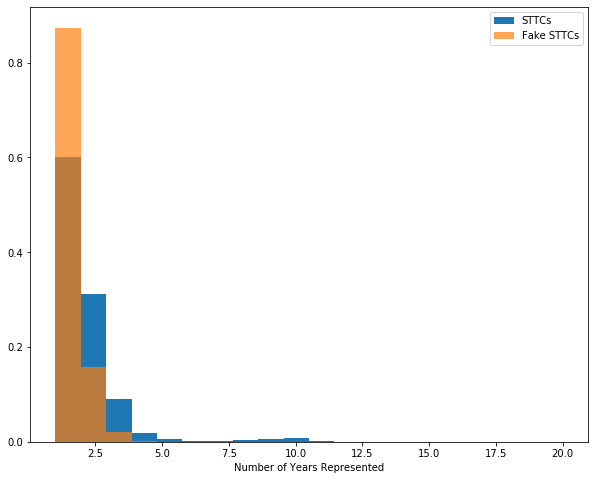

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(sttc_n_years, bins=20, range=(1, 20), density=True, label='STTCs');
ax.hist(fake_sttc_n_years, bins=20, range=(1, 20), density=True, alpha=0.7, label='Fake STTCs')
ax.legend(loc=1)
ax.set_xlabel("Number of Years Represented");

In [10]:
sttc_dyears = [max(x.data.index.levels[0]) - min(x.data.index.levels[0]) for x in rdr.sttcs.values()]

fake_sttc_dyears = []
for dset in fake_dataset:
    fake_sttc_dyears += [max(x.data.index.levels[0]) - min(x.data.index.levels[0]) for x in dset.sttcs.values()]

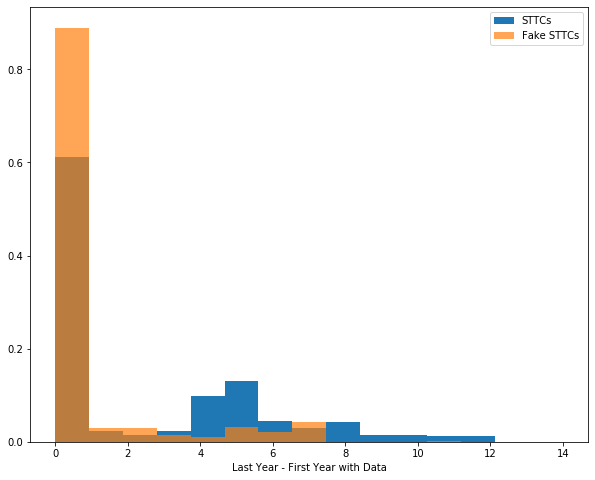

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(sttc_dyears, bins=15, range=(0, 14), density=True, label='STTCs');
ax.hist(fake_sttc_dyears, bins=15, range=(0, 14), density=True, alpha=0.7, label='Fake STTCs')
ax.legend(loc=1)
ax.set_xlabel("Last Year - First Year with Data");

In [12]:
sttc_startyears = [min(x.data.index.levels[0]) for x in rdr.sttcs.values()]

fake_sttc_startyears = []
for dset in fake_dataset:
    fake_sttc_startyears += [min(x.data.index.levels[0]) for x in dset.sttcs.values()]

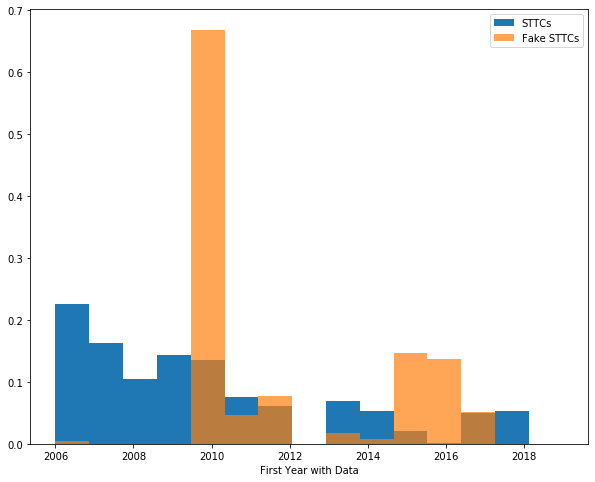

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(sttc_startyears, bins=15, range=(2006, 2019), density=True, label='STTCs');
ax.hist(fake_sttc_startyears, bins=15, range=(2006, 2019), density=True, alpha=0.7, label='Fake STTCs')
ax.legend(loc=1)
ax.set_xlabel("First Year with Data");

# Estimate-to-Estimate Variation for 2018

This test checks how much estimates differ between different draws of fake data.  An excellent predictive algorithm should minimize this variation.

We can measure this variation by determining the standard deviation divided by the mean, i.e. the **coefficient of variation (COV)**, for each short term count location.  We'll take 2018 as a representative year.

In [14]:
want_year = 2018

In [15]:
teps_estimates = []
for dset in tqdm(fake_dataset, desc='Running countmatch_teps'):
    teps_estimates.append(
        cmt.estimate_aadts(dset, nb, want_year, n_neighbours=5,
                           single_direction=True, progress_bar=False))

In [16]:
def get_estimate_averages(estimates):
    aadts = pd.concat(
        [(x.sort_values('Count ID')[['Count ID', 'AADT Estimate']]
          .set_index('Count ID', drop=True))
         for x in estimates], axis=1)
    aadts.columns = list(range(len(estimates)))
    aadts['average'] = aadts.mean(axis=1)
    aadts['std'] = aadts.std(axis=1)
    aadts['cov'] = aadts['std'] / aadts['average']
    return aadts

teps_aadts = get_estimate_averages(teps_estimates)

In [17]:
hybrid_estimates = []
for dset in tqdm(fake_dataset, desc='Running countmatch_hybrid'):
    hybrid_estimates.append(
        cmh.estimate_aadts(dset, nb, want_year, n_neighbours=5,
                           single_direction=True, progress_bar=False))

In [18]:
hybrid_estimates_ggf = []
for dset in tqdm(fake_dataset, desc='Running countmatch_hybrid_ggf'):
    hybrid_estimates_ggf.append(
        cmh.estimate_aadts(dset, nb, want_year, n_neighbours=5,
                           override_growth_factor=True,
                           single_direction=True, progress_bar=False))

In [19]:
bagheri_estimates_mseggf = []
for dset in tqdm(fake_dataset, desc='Running countmatch_bagheri_mseggf'):
    bagheri_estimates_mseggf.append(
        cmb.estimate_aadts(dset, nb, want_year, n_neighbours=5,
                           override_growth_factor=True, erroralgo='Minimum MSE',
                           single_direction=True, progress_bar=False))

In [20]:
hybrid_aadts = get_estimate_averages(hybrid_estimates)

In [21]:
hybrid_ggf_aadts = get_estimate_averages(hybrid_estimates_ggf)

In [22]:
bagheri_mseggf_aadts = get_estimate_averages(bagheri_estimates_mseggf)

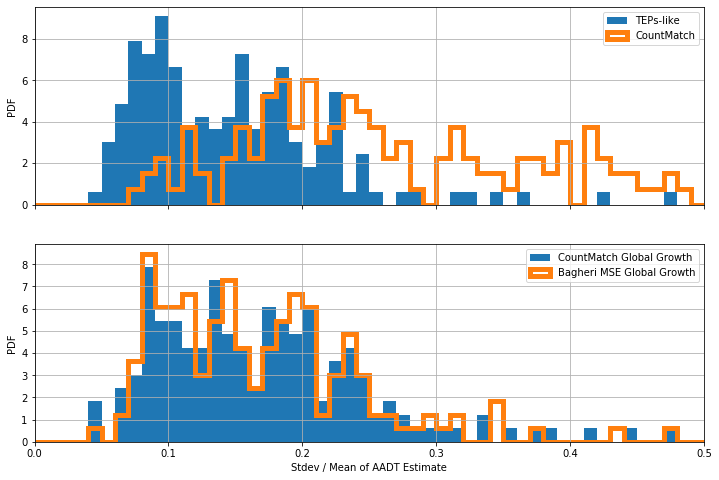

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
teps_aadts['cov'].hist(ax=ax[0], bins=50, range=(0., 0.5), density=True, label='TEPs-like',
                       lw=2)
hybrid_aadts['cov'].hist(ax=ax[0], bins=50, range=(0., 0.5), density=True, label='CountMatch',
                         histtype='step', lw=5)
hybrid_ggf_aadts['cov'].hist(ax=ax[1], bins=50, range=(0., 0.5), density=True, label='CountMatch Global Growth',
                             lw=2)
bagheri_mseggf_aadts['cov'].hist(ax=ax[1], bins=50, range=(0., 0.5), density=True, label='Bagheri MSE Global Growth',
                                 histtype='step', lw=5)
ax[0].legend(loc=1)
ax[1].legend(loc=1)
ax[1].set_xlabel('Stdev / Mean of AADT Estimate')
ax[0].set_ylabel('PDF')
ax[1].set_ylabel('PDF')
ax[1].set_xlim([0, 0.5]);

In [24]:
teps_aadts['cov'].median()

0.1370117153257946

In [37]:
hybrid_aadts['cov'].median()

0.2688912811665667

In [38]:
hybrid_ggf_aadts['cov'].median()

0.15973913107571402

In [25]:
bagheri_mseggf_aadts['cov'].median()

0.154003264655094

Conclusions:
* The TEPs emulator has the least COV variation, as measured by the median.  The countmatch default method is the worst ("hybrid", which combines elements of TEPs and Bagheri).
* The reason for this is largely because of using individual station growth rates - if we force the use of the global growth rate, we can reduce the variation down to near TEPs level.

## Prediction vs. Ground Truth

Of course, looking at prediction-to-prediction variation is only a test of sensitivity.  We need to examine how accurate the models are, but we can only do that when predicting for sites where we know the AADT, and which years it is known varies from station to station.  I therefore rigged up a validator that generates fake data as before, but then cycles through the years, prediction AADTs for each station where a ground truth value is known.

This is computationally intensive, so only 10 sets of fake data are generated per experiment.

In [26]:
rdr = reader.Reader(vol_conn)
rdr.read()
gf.get_growth_factors(rdr)

ptc_ids = np.unique(np.abs(list(rdr.ptcs.keys())))
nb = neighbour.NeighbourLonLatEuclidean(ll_conn, 20, ptc_ids)
nb.find_neighbours()

In [27]:
n_sets = 10

In [28]:
teps_datasets, teps_aadt = cmv.validation(
    rdr, nb, cmt.estimate_aadts, n_sets=n_sets, progress_bar=True)

For year 2006



For year 2010



For year 2011



For year 2012



For year 2013



For year 2014



For year 2015



For year 2016



For year 2017


In [29]:
cm_datasets, cm_aadt = cmv.validation(
    rdr, nb, cmh.estimate_aadts, n_sets=n_sets, progress_bar=True)

For year 2006



For year 2010



For year 2011



For year 2012



For year 2013



For year 2014



For year 2015



For year 2016



For year 2017


In [30]:
cm_ggf_datasets, cm_ggf_aadt = cmv.validation(
    rdr, nb, cmh.estimate_aadts, algo_args={'override_growth_factor': True},
    n_sets=n_sets, progress_bar=True)

For year 2006



For year 2010



For year 2011



For year 2012



For year 2013



For year 2014



For year 2015



For year 2016



For year 2017


In [31]:
bag_datasets, bag_aadt = cmv.validation(
    rdr, nb, cmb.estimate_aadts, algo_args={'override_growth_factor': False},
    n_sets=n_sets, progress_bar=True)

For year 2006



For year 2010



For year 2011



For year 2012



For year 2013



For year 2014



For year 2015



For year 2016



For year 2017


In [32]:
bag_ggf_datasets, bag_ggf_aadt = cmv.validation(
    rdr, nb, cmb.estimate_aadts, algo_args={'override_growth_factor': True},
    n_sets=n_sets, progress_bar=True)

For year 2006



For year 2010



For year 2011



For year 2012



For year 2013



For year 2014



For year 2015



For year 2016



For year 2017


In [33]:
bag_cov_ggf_datasets, bag_cov_ggf_aadt = cmv.validation(
    rdr, nb, cmb.estimate_aadts,
    algo_args={'erroralgo': 'Minimum COV', 'override_growth_factor': True},
    n_sets=n_sets, progress_bar=True)

For year 2006



For year 2010



For year 2011



For year 2012



For year 2013



For year 2014



For year 2015



For year 2016



For year 2017


In [77]:
import plotly.offline as pltly
import plotly.graph_objs as go
pltly.init_notebook_mode(connected=True)

import knowyourdata as kyd

import statsmodels.api as sm


def make_ploty_scatter(plt_data, title):

    scatter_data = []
    for i in range(len(plt_data)):
        year = plt_data[i].iat[0, -1]
        data = plt_data[i]
        
        scatter_data.append(
            go.Scatter(
                x=data.loc[:, 'Ground Truth'].values,
                y=data.loc[:, 0].values,
                mode='markers',
                hovertemplate="%{x:0.3f}, %{y:0.3f}",
                marker=dict(size=14,
                            line=dict(width=1),
                            color=defaultcolours[i % 10]),
                name=str(year)
            ))

    layout = go.Layout(
        title=title,
        width=900,
        height=600,
        hovermode='closest',
        xaxis=dict(
            title='Ground Truth',
            ticklen= 1000,
            zeroline= False,
            gridwidth= 2,
        ),
        yaxis=dict(
            title='Typical Prediction',
            ticklen= 1000,
            gridwidth= 2,
        ),
        showlegend=True
    )

    fig = go.Figure(data=scatter_data, layout=layout)
    pltly.iplot(fig)


def check_mape(plt_data):
    all_data = pd.concat(plt_data)
    all_data['MAPE'] = all_data['MAE'] / all_data['Ground Truth']
    kyd.kyd(all_data['MAPE']);

    
def linear_fit(plt_data):
    all_data = pd.concat(plt_data)
    x = np.concatenate([all_data.loc[:, i].values for i in range(n_sets)])
    y = np.concatenate(n_sets * [all_data.loc[:, 'Ground Truth'].values, ])

    model = sm.OLS(endog=y, exog=x)
    return "Slope: {0}".format(*model.fit().params)

### TEPs Emulator

In [51]:
make_ploty_scatter(teps_aadt, 'TEPs Emulator')

In [50]:
check_mape(teps_aadt)

| Basic Statistics                                          | Array Structure              	|
|                                                           |                              	|
|    Mean:         Min:   0.02574     -99 CI:   0.03247     | Number of Dimensions:   1    	|
|    0.1666         1Q:   0.08411     -95 CI:   0.04328     | Shape of Dimensions:    (303,)	|
|               Median:   0.1253      -68 CI:   0.06952     | Array Data Type:        float64	|
|   Std Dev:        3Q:   0.1964      +68 CI:   0.2495      | Memory Size:            2.5KiB	|
|    0.1344        Max:   0.8349      +95 CI:   0.5796      |                              	|
|                                     +99 CI:   0.7892      | Number of NaN:  0            	|
|                                                           | Number of Inf:  0            	|

In [78]:
linear_fit(teps_aadt)

'Slope: 0.9287569582309836'

### CountMatch Default ("Hybrid")

In [62]:
make_ploty_scatter(cm_aadt, 'CountMatch Default')

In [59]:
check_mape(cm_aadt)

| Basic Statistics                                          | Array Structure              	|
|                                                           |                              	|
|    Mean:         Min:   0.03461     -99 CI:   0.03786     | Number of Dimensions:   1    	|
|    0.3007         1Q:   0.1023      -95 CI:   0.05209     | Shape of Dimensions:    (303,)	|
|               Median:   0.155       -68 CI:   0.08755     | Array Data Type:        float64	|
|   Std Dev:        3Q:   0.2624      +68 CI:   0.3565      | Memory Size:            2.5KiB	|
|    0.5981        Max:   6.863       +95 CI:   1.479       |                              	|
|                                     +99 CI:   4.247       | Number of NaN:  0            	|
|                                                           | Number of Inf:  0            	|

In [79]:
linear_fit(cm_aadt)

'Slope: 0.2593844577203524'

### CountMatch Default with Global Growth Rate

In [64]:
make_ploty_scatter(cm_ggf_aadt, 'CountMatch Default Global Growth Rate')

In [65]:
check_mape(cm_ggf_aadt)

| Basic Statistics                                          | Array Structure              	|
|                                                           |                              	|
|    Mean:         Min:   0.01575     -99 CI:   0.01928     | Number of Dimensions:   1    	|
|    0.1822         1Q:   0.08824     -95 CI:   0.04297     | Shape of Dimensions:    (303,)	|
|               Median:   0.1377      -68 CI:   0.07056     | Array Data Type:        float64	|
|   Std Dev:        3Q:   0.2149      +68 CI:   0.2502      | Memory Size:            2.5KiB	|
|    0.2182        Max:   2.997       +95 CI:   0.546       |                              	|
|                                     +99 CI:   1.212       | Number of NaN:  0            	|
|                                                           | Number of Inf:  0            	|

In [80]:
linear_fit(cm_ggf_aadt)

'Slope: 0.9185862096967297'

### Bagheri MSE with Global Growth Rate

In [67]:
make_ploty_scatter(bag_ggf_aadt, 'Bagheri MSE Global Growth Rate')

In [68]:
check_mape(bag_ggf_aadt)

| Basic Statistics                                          | Array Structure              	|
|                                                           |                              	|
|    Mean:         Min:   0.02613     -99 CI:   0.03379     | Number of Dimensions:   1    	|
|    0.1778         1Q:   0.09204     -95 CI:   0.04395     | Shape of Dimensions:    (303,)	|
|               Median:   0.1379      -68 CI:   0.07621     | Array Data Type:        float64	|
|   Std Dev:        3Q:   0.2016      +68 CI:   0.2573      | Memory Size:            2.5KiB	|
|    0.1585        Max:   1.619       +95 CI:   0.6016      |                              	|
|                                     +99 CI:   0.9312      | Number of NaN:  0            	|
|                                                           | Number of Inf:  0            	|

In [81]:
linear_fit(bag_ggf_aadt)

'Slope: 0.9299173221596153'

### Bagheri COV with Global Growth Rate

In [71]:
make_ploty_scatter(bag_cov_ggf_aadt, 'Bagheri MSE Global Growth Rate')

In [72]:
check_mape(bag_cov_ggf_aadt)

| Basic Statistics                                          | Array Structure              	|
|                                                           |                              	|
|    Mean:         Min:   0.02193     -99 CI:   0.03031     | Number of Dimensions:   1    	|
|    0.1658         1Q:   0.08501     -95 CI:   0.03567     | Shape of Dimensions:    (303,)	|
|               Median:   0.1337      -68 CI:   0.07157     | Array Data Type:        float64	|
|   Std Dev:        3Q:   0.2067      +68 CI:   0.2518      | Memory Size:            2.5KiB	|
|    0.1197        Max:   0.8273      +95 CI:   0.4952      |                              	|
|                                     +99 CI:   0.6295      | Number of NaN:  0            	|
|                                                           | Number of Inf:  0            	|

In [82]:
linear_fit(bag_cov_ggf_aadt)

'Slope: 0.9316624134576739'

Analysis:
* We measure mean absolute percentage error (MAPE) using `check_mape`, total error using the plots, and systematic bias using the slope of a linear fit of prediction vs ground truth.
* The plots are for a single dataset draw, and not averaged between different datasets.  `check_mape` calculates MAPE for each observation to generate its distribution.  The linear fit uses all data for the fit, so is not a check of variance (nor does it presume to be one).
* Again, using individual PTC growth rates leads to large outliers (both positive and negative); eliminating it leads performance similar to TEPs default.
* MAPE doesn't noticably improve between TEPs, CountMatch default with global growth rate or either of the Bagheri methods, but the dispersion of points in the plots is noticably reduced with the CountMatch default, which makes it possibly the best of all the algorithms.
* There's not too much to be gained by switching from CountMatch's hybrid method to either Bagheri method, especially Bagheri COV.  Here we reproduce Bagheri's own finding that the COV method has poorer accuracy.
* Every method predicts systematically smaller AADT than the ground truth by about 10%